In [1]:
import tskit
import stdpopsim
import numpy as np
import yaml
from matplotlib import pyplot as plt
import statsmodels.api as sm
import os

In [2]:
with open('workflows/config/snakemake/sweep_config.yaml') as f:
     config = yaml.safe_load(f)

In [3]:
rng = np.random.default_rng(seed=config["seed"])
rng2 = np.random.default_rng(seed=config["seed"]+1)
seed_array = rng.integers(1,2**31,config["replicates"])
seed2_array = rng2.integers(1,2**31,config["boundary_reps"])

In [4]:
output_dir = os.path.abspath(config["output_dir"])

tss_path = [output_dir + f"/simulated_data/sweeps/boundary_sims/sim_{seed}_{config['region_size']}.trees"
                 for seed in seed2_array]


In [5]:
divs=[]
for tspath in tss_path:
    ts = tskit.load(tspath)
    windows = np.arange(0,ts.sequence_length+1, 5000)
    div = ts.diversity(windows=windows,mode="site")
    a1,a2 = np.split(div,2)
    fdiv = np.stack((a2,a1[::-1])).mean(axis=0)
    divs.append(fdiv)
means = (np.mean(divs, axis=0))
all_wins = (windows[:-1][:len(windows)//2])

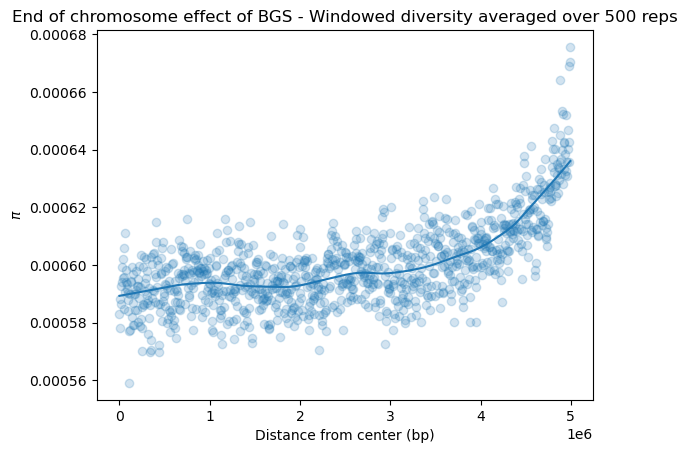

In [6]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
lowess = sm.nonparametric.lowess(means, all_wins, frac=.25)
ax.scatter(all_wins,means, alpha=0.2)
ax.plot(all_wins,lowess[:,1])
plt.ylabel(r'$\pi$')
plt.xlabel('Distance from center (bp)')
plt.title(f"End of chromosome effect of BGS - Windowed diversity averaged over {config['boundary_reps']} reps")
#plt.legend(title="Buffer size")
fig.savefig('results/simulated_data/sweeps/boundary_effect_bgs.png', bbox_inches="tight")   # save the figure to file
#plt.close(fig)  

In [7]:
species = stdpopsim.get_species(config["species"])
contig = species.get_contig(length=config['region_size'])
# Assuming effect dissipates after 2Mb, it equals to 2.5cM
contig.recombination_map.get_cumulative_mass(2000000)*100

2.5640804792601775